In [1]:
#!pip install boto3 pandas tensorflow mlflow

# Fit a basic model and export to mlflow

In [2]:
import pandas as pd
df = pd.read_csv('BTC-2021min.csv')
df['unix'] = pd.to_datetime(df['unix'], unit='s')
df = df.set_index(pd.DatetimeIndex(df['unix']))
df = df.drop(df[['open', 'high', 'low', 'symbol', 'Volume BTC', 'Volume USD', 'date', 'unix']], axis=1)
df.sort_values(by='unix', inplace=True)

<AxesSubplot:xlabel='unix'>

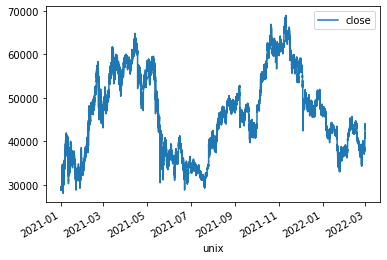

In [3]:
df.plot()

In [4]:
df.describe()

,close
count,610782.000000
mean,46482.567211
std,9454.107853
min,28073.030000
25%,38129.137500
50%,46667.295000
75%,54907.412500
max,69000.000000


# Do some feature engineering

In [5]:
df['y'] = df['close'].shift(-1)
df['7ma'] = df['close'].rolling(window=7).mean()
df['50ma'] = df['close'].rolling(window=50).mean()
df['short_trend'] = df['7ma'].diff(7)
df['long_trend'] = df['50ma'].diff(50)
df['weekday'] = df.index.weekday
df = df.dropna()
df = df[:-1]

In [6]:
df

,close,y,7ma,50ma,short_trend,long_trend,weekday
unix,,,,,,,
2021-01-01 01:40:00,29451.85,29443.61,29460.647143,29274.4150,37.428571,322.9620,4
2021-01-01 01:41:00,29443.61,29438.16,29461.764286,29283.0154,28.725714,332.9600,4
2021-01-01 01:42:00,29438.16,29442.38,29466.571429,29290.7984,33.262857,340.4806,4
2021-01-01 01:43:00,29442.38,29403.39,29463.730000,29298.6540,28.068571,348.3068,4
2021-01-01 01:44:00,29403.39,29416.32,29451.448571,29306.0570,16.592857,355.9488,4
...,...,...,...,...,...,...,...
2022-03-01 03:36:00,43090.55,43088.92,43097.060000,43073.1788,83.454286,-81.5870,1
2022-03-01 03:37:00,43088.92,43049.46,43096.402857,43071.9328,71.141429,-80.3784,1
2022-03-01 03:38:00,43049.46,42999.44,43088.087143,43070.1776,51.805714,-79.7030,1


# Generate Train Test split

In [7]:
from sklearn.model_selection import train_test_split
random_state = 42
train_size = 0.8
X = df[['close', '7ma', '50ma', 'short_trend', 'long_trend', 'weekday']]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, random_state=random_state) 

# Configure MLFlow endpoint

In [8]:
import os
import mlflow

os.environ["AWS_ACCESS_KEY_ID"] = "mlflow"
os.environ["AWS_SECRET_ACCESS_KEY"] = "mlflow123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://mlflow-minio.mlflow.svc.cluster.local:9000/"
model_artifact_name = "model"

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")
mlflow.set_experiment("bitcoin")

<Experiment: artifact_location='s3://mlflow/1', experiment_id='1', lifecycle_stage='active', name='bitcoin', tags={}>

# Fit and export the model

In [9]:
import logging
import mlflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(random_state)
tf.random.set_seed(random_state) 

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

if __name__ == "__main__":
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        
        model = Sequential()
        model.add(Dense(32, input_shape=(X_train.shape[-1],), activation="relu", name="hidden_layer"))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss="mse", optimizer="adam")
        
        model.fit(X_train, y_train, epochs=8, batch_size=100, validation_split=.2)
               
        # Evaluate the best model with testing data.
        y_hat = model.predict(X_test)
        (rmse, mae, r2) = eval_metrics(y_test, y_hat)
        mlflow.log_param("framework", "tensorflow")
        mlflow.log_param("version", tf.__version__)
        mlflow.log_param("random_state", random_state)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        lr = res = {"lr_" + str(key): val for key, val in model.optimizer.get_config().items()}
        mlflow.log_params(lr)
        info = mlflow.keras.log_model(model, model_artifact_name, registered_model_name="BitcoinForecast")
        
        uri = mlflow.get_artifact_uri()

2022-09-17 18:15:02.488220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 18:15:02.859284: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-17 18:15:02.872362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-17 18:15:02.872391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Epoch 1/8
   1/3909 [..............................] - ETA: 36:33 - loss: 480778528.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.


3909/3909 [==============================] - 10s 2ms/step - loss: 496458.0625 - val_loss: 4638.5576
Epoch 2/8
3909/3909 [==============================] - 9s 2ms/step - loss: 10470.7598 - val_loss: 10217.9277
Epoch 3/8
3909/3909 [==============================] - 10s 3ms/step - loss: 12249.5381 - val_loss: 4933.0508
Epoch 4/8
3909/3909 [==============================] - 12s 3ms/step - loss: 10617.3164 - val_loss: 3708.5649
Epoch 5/8
3909/3909 [==============================] - 10s 2ms/step - loss: 10094.7812 - val_loss: 10528.3643
Epoch 6/8
3909/3909 [==============================] - 13s 3ms/step - loss: 9168.2090 - val_loss: 3674.7446
Epoch 7/8
3909/3909 [==============================] - 9s 2ms/step - loss: 8771.3896 - val_loss: 12103.9658
Epoch 8/8
3909/3909 [==============================] - 9s 2ms/step - loss: 8306.2197 - val_loss: 3604.7859
INFO:tensorflow:Assets written to: /tmp/tmp1qwm9rh8/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp1qwm9rh8/model/data/model/assets
2022/09/17 18:16:33 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


3817/3817 [==============================] - 6s 1ms/step
INFO:tensorflow:Assets written to: /tmp/tmp8l6umzz1/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp8l6umzz1/model/data/model/assets
2022/09/17 18:16:48 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'BitcoinForecast' already exists. Creating a new version of this model...
2022/09/17 18:16:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: BitcoinForecast, version 6
Created version '6' of model 'BitcoinForecast'.


# Update the inferenseservice yaml

In [10]:
storage_uri = f"{uri}/{model_artifact_name}"

In [11]:
#https://github.com/ipython/ipython/issues/6701
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate ../../deployments/basic-model/isvc.yaml

apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "bitcoin-forecast"
  namespace: default
  labels:
    networking.knative.dev/visibility: cluster-local
spec:
  predictor:
    serviceAccountName: sa-s3
    model:
      modelFormat:
        name: mlflow
      protocolVersion: v2
      storageUri: {storage_uri}